In [112]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
# from sklearn.metrics import accuracy_score, precision_score, recall_score
import tensorflow as tf
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt


## Data Preprocessing

In [113]:
# Hyperparameters

# y column normalize scaler
normalizer_constant = 2

# time series step size
time_step = 14

# NN parameters
learning_rate = 0.1
num_epoch = 500
NN_layer_dimension = [100,100]
train_size = 568 # 80% of the data

In [194]:
SNP = pd.read_csv('./SP500.csv')

# get all attributes
SNP_attributes = SNP.iloc[:,2:7]
# get last column (y)
SNP_price = SNP.iloc[:,-1:]

# normalize the data using MinMax scaller
scaler = MinMaxScaler()
scaler.fit(SNP_attributes)
SNP_attributes = scaler.transform(SNP_attributes)

Price_scaler = MinMaxScaler(feature_range=(0,1))
Price_scaler.fit(SNP_price)
SNP_price = Price_scaler.transform(SNP_price)

# scale data to [0,1]
# SNP_price = (SNP_price-SNP_price.min())/((SNP_price.max()*normalizer_constant)-SNP_price.min())

train_data = SNP_price[0:train_size, :]
train_data_mul = SNP_attributes[0:train_size, :]
# train_data_mul = np.array(train_data_mul)

# univariate
def create_train_data(data):
    x = []
    y = []
    for i in range(time_step, len(data)):
        x.append(data[i-time_step:i,0])
        y.append(data[i,0])
    return x, y

# multivariate
def create_train_data_mul(data):
    x = []
    y = []
    for i in range(time_step, len(data)):
        x.append(data[i-time_step:i, 0:data.shape[1]])
        y.append(data[i:i+1,0])
    return x, y

X_train, y_train = create_train_data_mul(train_data_mul)


In [195]:
# Reshaping 
X_train, y_train = np.array(X_train), np.array(y_train)
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [196]:
# NN 
def create_model(units=[12,3], learning_rate=0.3):
    model = tf.keras.models.Sequential()
    # # LSTM RNN model
    model.add(LSTM(units=64,return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=32,return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))

    # opt = tf.keras.optimizers.Adam(learning_rate=0.1)
    model.compile(optimizer='adam',loss='mean_squared_error')

    return model

model = create_model(units=NN_layer_dimension, learning_rate=learning_rate)

In [197]:
# Train
model.fit(X_train, y_train, epochs=num_epoch, batch_size=20, verbose=1)

Epoch 1/500
28/28 [==============================] - 2s 9ms/step - loss: 0.0025
Epoch 2/500
28/28 [==============================] - 0s 7ms/step - loss: 6.3660e-04
Epoch 3/500
28/28 [==============================] - 0s 8ms/step - loss: 5.0975e-04
Epoch 4/500
28/28 [==============================] - 0s 7ms/step - loss: 4.4080e-04
Epoch 5/500
28/28 [==============================] - 0s 7ms/step - loss: 3.0063e-04
Epoch 6/500
28/28 [==============================] - 0s 7ms/step - loss: 3.6302e-04
Epoch 7/500
28/28 [==============================] - 0s 7ms/step - loss: 4.3054e-04
Epoch 8/500
28/28 [==============================] - 0s 7ms/step - loss: 3.9094e-04
Epoch 9/500
28/28 [==============================] - 0s 8ms/step - loss: 3.7316e-04
Epoch 10/500
28/28 [==============================] - 0s 7ms/step - loss: 3.4601e-04
Epoch 11/500
28/28 [==============================] - 0s 7ms/step - loss: 3.0990e-04
Epoch 12/500
28/28 [==============================] - 0s 7ms/step - loss: 2.92

In [202]:
model.save('./NN_model')

2022-05-13 22:45:28.212438: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./NN_model/assets


INFO:tensorflow:Assets written to: ./NN_model/assets


In [199]:
# test data 
test_data = SNP_price[train_size - time_step:, :]
test_data_mul = SNP_attributes[train_size - time_step:, :]
# test_data_mul = np.array(test_data_mul)
X_test = []
X_test_mul = []
y_test = SNP_price[train_size:, :]
for i in range(time_step, len(test_data)):
    X_test.append(test_data[i-time_step:i,0])


for i in range(time_step, len(test_data_mul)):
    X_test_mul.append(test_data_mul[i-time_step:i,0:test_data_mul.shape[1]])


X_test, X_test_mul = np.array(X_test), np.array(X_test_mul)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test_mul = np.reshape(X_test_mul, (X_test_mul.shape[0], X_test_mul.shape[1], X_test_mul.shape[2]))


In [200]:
# predicted_price = model.predict(X_test)
predicted_price_mul = model.predict(X_test_mul)
# predicted_price = Price_scaler.inverse_transform(predicted_price)
predicted_price_mul = np.repeat(predicted_price_mul,X_test_mul.shape[2],axis=-1)
predicted_price_mul = scaler.inverse_transform(predicted_price_mul)[:,0]
predicted_price_mul

array([ 789.98865,  759.7035 ,  784.249  ,  678.80597,  800.63666,
        861.8041 ,  971.8518 , 1083.9847 , 1122.8834 , 1056.8872 ,
       1049.4579 , 1144.1514 , 1239.4596 , 1297.363  , 1194.8275 ,
       1242.9587 , 1244.4358 , 1149.9755 , 1198.6375 , 1116.447  ,
       1101.9165 , 1071.0792 , 1197.5961 , 1206.43   , 1328.8698 ,
       1402.684  , 1427.689  , 1436.6711 , 1409.7688 , 1308.8442 ,
       1212.3553 , 1324.5336 , 1188.7238 , 1124.0166 , 1163.5891 ,
       1228.3191 , 1259.225  , 1317.2085 , 1263.6721 , 1415.2549 ,
       1422.7063 , 1416.8796 , 1422.0813 , 1368.641  , 1369.178  ,
       1338.6583 , 1449.1444 , 1458.794  , 1508.18   , 1533.581  ,
       1632.9188 , 1566.8365 , 1688.0753 , 1537.4146 , 1644.2029 ,
       1697.9218 , 1689.0688 , 1708.3556 , 1673.6389 , 1833.2219 ,
       1800.4607 , 1817.573  , 1845.9473 , 1860.0985 , 1785.0437 ,
       1845.6714 , 1764.1134 , 1893.5004 , 1891.6898 , 1859.841  ,
       1847.6826 , 1978.3402 , 1819.3209 , 1904.6588 , 1843.45

/var/folders/86/p93c5vrd78lblk3lsz04s3r00000gn/T/ipykernel_4605/161469088.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = predicted_price_mul


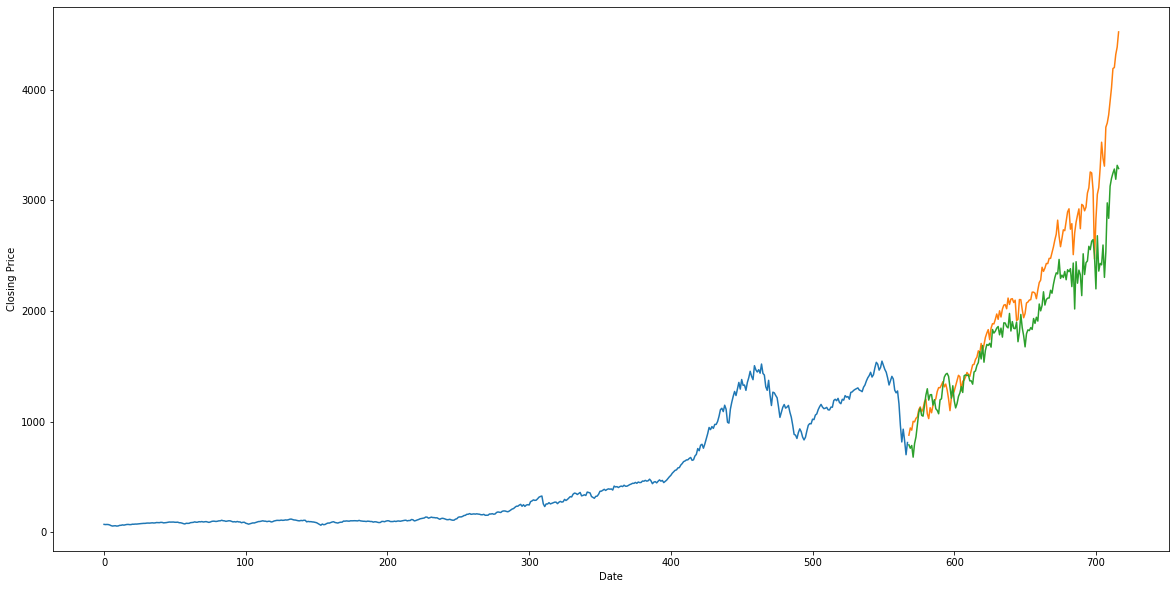

In [201]:
plt.figure(figsize=(20,10))
training = SNP[:train_size]
valid = SNP[train_size:]
valid['pred'] = predicted_price_mul


#plot
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.plot(training["Closing Price"])
plt.plot(valid[['Closing Price', 'pred']])

